# Data Science mit gebrauchten Autos von Willhaben

Hier befassen wir uns mit der Analyse des Datensatzes

In [1]:
import pandas as pd
import numpy as np
import gc
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_rows = 30

In [42]:
df = pd.read_csv("./data/final.csv", sep=";")

C:\Users\Admin\AppData\Local\Temp\ipykernel_6100\4230953392.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/final.csv", sep=";")



## 1. Feature Engineering

Das erste Ziel ist den Datensatz kennenzulernen. Dabei untersuchen wir die vorhandenen Features mittels deskriptiver Methoden. 

In [3]:
df.columns

Index(['id', 'description', 'product_id', 'heading', 'body_dyn', 'price',
       'year_model', 'mileage', 'brand', 'model', 'car_type', 'no_of_owners',
       'noofseats', 'engine_effect', 'engine_fuel_resolved',
       'transmission_resolved', 'condition_resolved', 'warranty_resolved',
       'published_string', 'country', 'coordinates', 'postcode', 'state',
       'district', 'address', 'location', 'orgname', 'fnmmocount',
       'upselling_ad_searchresult', 'isprivate', 'equipment_resolved'],
      dtype='object')

Wir entfernen ein paar wenig versprechende Spalten:

In [43]:
df = df.drop(columns=["product_id", "published_string", "condition_resolved", "country", "noofseats",
                      "fnmmocount", "upselling_ad_searchresult", "no_of_owners", "address", "description"])


In [5]:
df.head(5)

,id,heading,body_dyn,price,year_model,mileage,brand,model,car_type,engine_effect,engine_fuel_resolved,transmission_resolved,warranty_resolved,coordinates,postcode,state,district,location,orgname,isprivate,equipment_resolved
0,612174978,Skoda Octavia Combi Style TSI ACT,-,34990,2022,4500,Skoda,Octavia,Kombi / Family Van,110,Benzin,Schaltgetriebe,Nein,"47.05489,15.1365",8570,Steiermark,Voitsberg,Voitsberg,F. Fripertinger GmbH,0,Bordcomputer|elektr. Fensterheber|Sitzheizung|Zentralverriegelung|Beifahrerairbags|Anhängerkupplung|Stabilitätsprogramme (ESP)|Keyless entry|Mittelarmlehne|Nebelscheinwerfer|Tagfahrlicht|Freisprecheinrichtung|Rückfahrkamera|Sportpaket|LED-Scheinwerfer|Klimaautomatik|Media-Interface / mp3|Aut. Heckklappe|ABS|Antriebsschlupfregelung (ASR)|Klimaanlage
1,612174235,VW Golf R-Line TDI 4MOTION DSG,Extras: Coming-Home-Funktion LED-Rückleuchten 3-Punktautomatikgurte hinten Climatronic Digitales Display Thermoverglasung Heckspoiler Frontscheibenantenne,43990,2022,3000,VW,Golf,Limousine,110,Diesel,Automatik,Nein,"47.44651,15.30058",8605,Steiermark,Bruck-Mürzzuschlag,Kapfenberg,Porsche Kapfenberg,0,Leichtmetall-/Alufelgen|Anhängerkupplung|elektr. Spiegel|Regensensor|Tagfahrlicht|Abstandstempomat|Rückfahrkamera|Spurhalteassistent|LED-Scheinwerfer|Reifendrucksensor|Parksensor vorne & hinten|Tempomat|Parksensor hinten
2,612174149,Seat Tarraco Xcellence 2.0 TDI DSG 4Drive,Extras: Fahrwerksregelung elektronisch Automatische Distanzregelung,38490,2019,40880,Seat,Tarraco,SUV / Geländewagen,110,Diesel,Automatik,Nein,"48.56585,13.98543",4150,Oberösterreich,Rohrbach,Rohrbach in Oberösterreich,Kneidinger Center GmbH,0,Leichtmetall-/Alufelgen|Bordcomputer|elektr. Fensterheber|Navigationssystem|Servolenkung|Radio|Sitzheizung|Tempomat|Kopfairbags|Beifahrerairbags|Seitenairbags|Anhängerkupplung|elektr. Spiegel|elektr. Sitze|Keyless entry|ISOFIX|Mittelarmlehne|Multifunktionslenkrad|Nebelscheinwerfer|Panoramadach|Parksensor hinten|Sportsitze|Freisprecheinrichtung|Rückfahrkamera|Spurhalteassistent|LED-Scheinwerfer|Klimaautomatik|Media-Interface / mp3|Parksensor vorne & hinten|Aut. Heckklappe|Klimaanlage|Zentralverriegelung
3,575429445,"Suzuki Vitara 1,4 Hybrid ALLGRIP 6AGS shine",Irrtümer und Tippfehler vorbehalten.,26500,2022,610,Suzuki,Vitara,SUV / Geländewagen,95,Hybrid Elektro/Benzin,Schaltgetriebe,Ja,"46.6682,12.99953",9640,Kärnten,Hermagor,Kötschach-Mauthen,Autohaus Presslauer-Webhofer GmbH,0,Servicegepflegt|Leasingfähig|elektr. Spiegel|elektr. Fensterheber|Klimaautomatik|Multifunktionslenkrad|Servolenkung|Sitzheizung|Start/Stopp-Automatik|Tempomat|Zentralverriegelung|Lederlenkrad|Leichtmetall-/Alufelgen|Metallic-Lackierung|ABS|Abstandstempomat|Beifahrerairbags|Fahrerairbag|Notbremsassistent|Reifendrucksensor|Seitenairbags|Spurhalteassistent|Totwinkelassistent|Lichtsensor|LED-Scheinwerfer|Nebelscheinwerfer|Tagfahrlicht|Rückfahrkamera|Bluetooth / USB|Bordcomputer|Freisprecheinrichtung|Media-Interface / mp3|Navigationssystem|Klimaanlage
4,575429451,"Suzuki Vitara 1,4 Hybrid ALLGRIP 6AGS flash",Fahrzeug verfügbar ab 09.2022. Irrtümer und Tippfehler vorbehalten.,27500,2022,620,Suzuki,Vitara,SUV / Geländewagen,95,Hybrid Elektro/Benzin,Schaltgetriebe,Ja,"46.6682,12.99953",9640,Kärnten,Hermagor,Kötschach-Mauthen,Autohaus Presslauer-Webhofer GmbH,0,Servicegepflegt|Leasingfähig|elektr. Spiegel|elektr. Fensterheber|Klimaautomatik|Multifunktionslenkrad|Regensensor|Servolenkung|Sitzheizung|Start/Stopp-Automatik|Tempomat|Zentralverriegelung|Lederlenkrad|Keyless entry|Leichtmetall-/Alufelgen|ABS|Abstandstempomat|Beifahrerairbags|Stabilitätsprogramme (ESP)|Fahrerairbag|Notbremsassistent|Reifendrucksensor|Seitenairbags|Spurhalteassistent|Totwinkelassistent|Lichtsensor|LED-Scheinwerfer|Nebelscheinwerfer|Tagfahrlicht|Parksensor hinten|Rückfahrkamera|Bluetooth / USB|Bordcomputer|Freisprecheinrichtung|Media-Interface / mp3|Navigationssystem|Antriebsschlupfregelung (ASR)|Klimaanlage


Aus den ersten fünf Zeilen sieht man, wo sich `pandas` schwer tut mit den Datentypen. Deshalb setzen wir die types selbst:

In [44]:
df = df.astype({
    "id": str,
    "body_dyn": str,
    "car_type": str,
    "engine_fuel_resolved": "category",
    "transmission_resolved": "category",
    "postcode": str,
    "equipment_resolved": str,
    "orgname": str
})


Anschließend erstellen wir ein paar neue Features, die für später relevant sein können:

In [45]:
## Feature Engineering (cleaning, new Features)
df["orgname"] = df["orgname"].apply(lambda x: str(x).strip())
df["fuel"] = df["engine_fuel_resolved"]
df["transmission"] = df["transmission_resolved"]
df["orgname"] = df["orgname"].replace(to_replace="nan", value="privat")


df["ln_price"] = df["price"].apply(lambda x: np.log(x) if x > 0 else 0)
df["ln_mileage"] = df["mileage"].apply(lambda x: np.log(x) if x > 0 else 0)
df["ln_mileage2"] = df["ln_mileage"]**2
df["age"] = 2022 - df["year_model"]
df["age2"] = df["age"]**2
df["has_warranty"] = df["warranty_resolved"].apply(lambda x: 1 if x in "Ja" else 0)
df["is_gewerblich"] = 1 - df["isprivate"]
df["ps"] = 1.36 * df["engine_effect"] 
df["ps2"] = df["ps"]**2

def check_defect(text: str):
    defect = 1 if sum([word in text.lower() for word in ["schaden", "unfall"]]) > 0 else 0
    return defect
df["has_defect"] = df["body_dyn"].apply(check_defect)

df["is_servicegepflegt"] = df["equipment_resolved"].apply(lambda x: 1 if "servicegepflegt" in x.lower() else 0)
df["is_leasing"] = df["equipment_resolved"].apply(lambda x: 1 if "leasingfähig" in x.lower() else 0)
df["has_alufelgen"] = df["equipment_resolved"].apply(lambda x: 1 if "alufelgen" in x.lower() else 0)
df["length_heading"] = df["heading"].apply(len)

def check_luxury(brand: str):
    luxury_brands = ["mercedes", "bmw", "audi", "porsche", "ferrari", "maseratti", 
            "bentley", "lamborghini", "aston martin"]
    is_luxury = 1 if brand.lower() in luxury_brands else 0
    return is_luxury
df["is_luxury"] = df["brand"].apply(check_luxury)

def check_sport(car_type: str):
    sport_type = ["cabrio", "roadster", "sportwagen", "coupé"]
    is_sport = 1 if sum([type in car_type.lower() for type in sport_type]) else 0 
    return is_sport
df["is_sport"] = df["car_type"].apply(check_sport)

Zusätzlich führen wir Dummy Variablen ein für `fuel` und `transmission`, die mehrere Ausprägungen haben. Eine Spalte entfernen wir, um die "Dummy Falle" bei der linearen Regression zu vermeiden. 

In [46]:
## Dummies
dummies = pd.concat([
    pd.get_dummies(df["fuel"], prefix="d"),
    pd.get_dummies(df["transmission"], prefix="d")
], axis=1)
# avoid dummy trap in lin reg
dummies = dummies.drop(columns=["d_Benzin", "d_Schaltgetriebe"])

df = pd.concat([df, dummies], axis=1)


Nach dem Feature Engineering räumen wir den Datensatz nochmal auf, in wem wir nicht benötigte Spalten entfernen und 

In [47]:
df = df.drop(columns=[
    "heading", "body_dyn", "engine_effect", "engine_fuel_resolved", "transmission_resolved",
    "warranty_resolved", "equipment_resolved", "isprivate",
])
df = df.drop_duplicates(subset="id")
gc.collect()


512

So schaut der finale Datensatz aus:

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 145428 entries, 0 to 220105
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       145428 non-null  object  
 1   price                    145428 non-null  int64   
 2   year_model               145428 non-null  int64   
 3   mileage                  145428 non-null  int64   
 4   brand                    145428 non-null  object  
 5   model                    145428 non-null  object  
 6   car_type                 145428 non-null  object  
 7   coordinates              145163 non-null  object  
 8   postcode                 145428 non-null  object  
 9   state                    145428 non-null  object  
 10  district                 145428 non-null  object  
 11  location                 145428 non-null  object  
 12  orgname                  145428 non-null  object  
 13  fuel                     145115 non-null  ca

## 2. Explorative Datenanalyse

Nun schauen wir uns den Datensatz mittels verschiedenster Plots an und hoffen erste explorative Erkenntnisse zu finden. Für die Plots benutzen wir `seaborn`, da mit relativ wenig Aufwand schöne Plots erzeugt werden. 

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

df.columns

Index(['id', 'price', 'year_model', 'mileage', 'brand', 'model', 'car_type',
       'coordinates', 'postcode', 'state', 'district', 'location', 'orgname',
       'fuel', 'transmission', 'ln_price', 'ln_mileage', 'age', 'has_warranty',
       'is_gewerblich', 'ps', 'has_defect', 'is_servicegepflegt', 'is_leasing',
       'has_alufelgen', 'length_heading', 'is_luxury', 'is_sport', 'd_Diesel',
       'd_Elektro', 'd_Gas', 'd_Hybrid Elektro/Benzin',
       'd_Hybrid Elektro/Diesel', 'd_Wasserstoff', 'd_Automatik'],
      dtype='object')

Wichtig wäre noch zu wissen, wie viele `NaN` im Datensatz sind. Dazu eignet sich ein Heatmap für den schnellen visuellen Scan. Da recht wenige Zeilen betroffen sind, droppen wir diese gleich mit. 

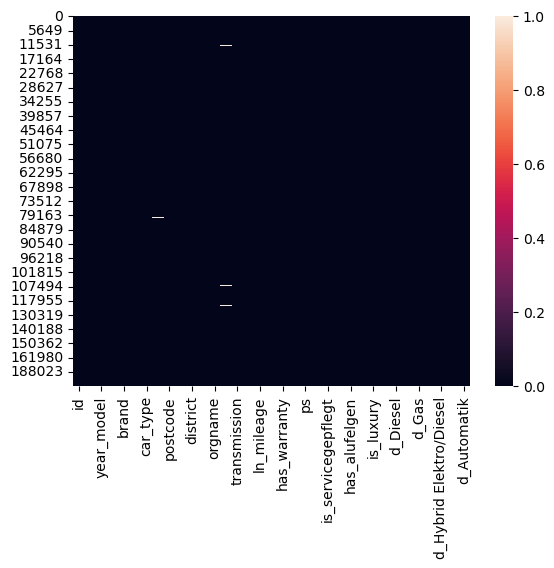

In [48]:
sns.heatmap(df.isna())
df = df.dropna()

Anschließend schauen wir uns einmal eine Summary der numerischen Daten an:

In [49]:
df.describe()

,price,year_model,mileage,ln_price,ln_mileage,age,has_warranty,is_gewerblich,ps,has_defect,is_servicegepflegt,is_leasing,has_alufelgen,length_heading,is_luxury,is_sport,d_Diesel,d_Elektro,d_Gas,d_Hybrid Elektro/Benzin,d_Hybrid Elektro/Diesel,d_Wasserstoff,d_Automatik
count,1.447510e+05,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000,144751.000000
mean,2.346876e+04,2013.016642,112812.315279,9.626011,10.739831,8.983358,0.195964,0.521516,157.157254,0.045589,0.460045,0.186120,0.672203,33.450539,0.264537,0.103751,0.553716,0.021720,0.000767,0.032594,0.009471,0.000048,0.466332
std,3.108771e+04,9.296146,91207.626376,1.036309,2.300358,9.296146,0.396942,0.499539,80.736482,0.208592,0.498403,0.389205,0.469412,17.090047,0.441088,0.304938,0.497108,0.145768,0.027681,0.177572,0.096860,0.006954,0.498867
min,1.000000e+00,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.800000e+03,2009.000000,32470.000000,9.082507,10.388072,3.000000,0.000000,0.000000,110.160000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.820000e+04,2016.000000,99328.000000,9.809177,11.506183,6.000000,0.000000,1.000000,140.080000,0.000000,0.000000,0.000000,1.000000,31.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.990000e+04,2019.000000,174000.000000,10.305614,12.066811,13.000000,0.000000,1.000000,187.680000,0.000000,1.000000,0.000000,1.000000,44.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,5.840000e+06,2022.000000,940000.000000,15.580241,13.753635,122.000000,1.000000,1.000000,1251.200000,1.000000,1.000000,1.000000,1.000000,662.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Einige recht interessante "stylized facts" kann man bereits über Mittelwerte erkennen:

- Im Durchschnitt kostet ein Auto EUR 23.400, hat ein Baujahr von 2013 (9 Jahre alt), ca 113.000 km Laufleistung und 157 PS. 
- Etwa 19% haben eine Garantie, 52% werden gewerblich angeboten und 19% sind leasingfähig.
- 4% hatten einen Unfall, 46% sind servicegepflegt, 67% haben Alufelgen, 26% sind Luxusmarken (Mercedes, BMW, ...)
- 55% sind Diesel, 2% sind Elektro, Rest sind hauptsächlich Benziner
- 46% haben eine Automatik, 10% sind sportliche Autos (Cabrios, Coupés)

Da Preise und Laufleistung sehr schiefe Verteilungen sein können, haben wir schon vorab die Logarithmen gebildet. Mit Histogramme überprüfen wir kurz, ob sich unsere Annahme bestätigt hat, dass es besser wäre mit Logs zu arbeiten. 

<AxesSubplot:xlabel='ln_mileage', ylabel='Count'>

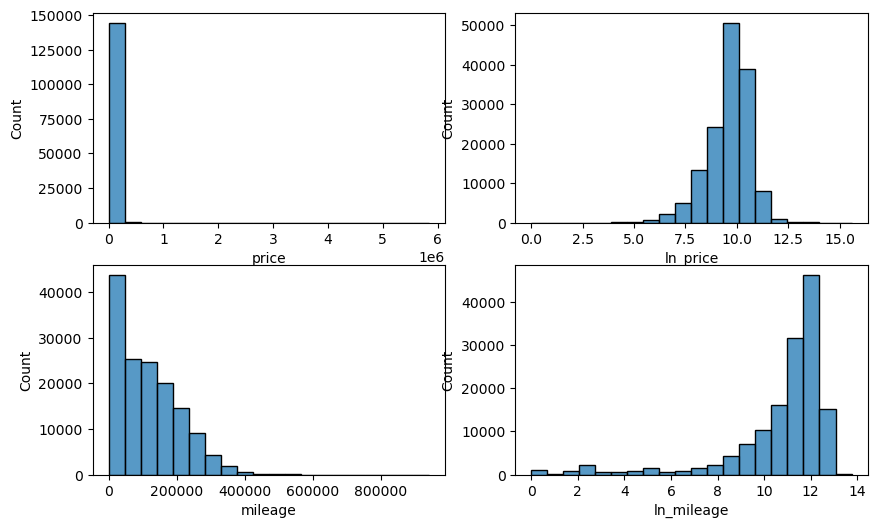

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
sns.histplot(ax=axes[0, 0], data=df, x="price", bins=20)
sns.histplot(ax=axes[0, 1], data=df, x="ln_price", bins=20)
sns.histplot(ax=axes[1, 0], data=df, x="mileage", bins=20)
sns.histplot(ax=axes[1, 1], data=df, x="ln_mileage", bins=20)


Und nun beide gemeinsam im Scatterplot:

<AxesSubplot:xlabel='ln_mileage', ylabel='ln_price'>

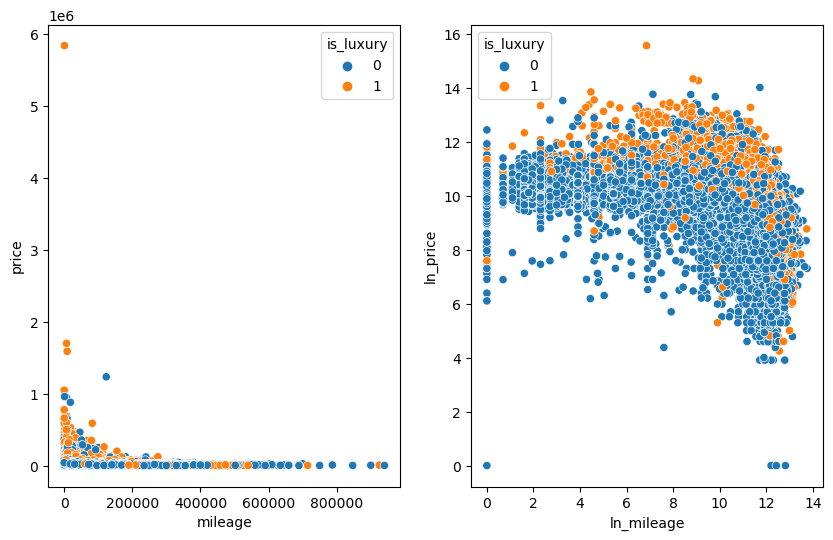

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.scatterplot(ax=axes[0], data=df, x="mileage", y="price", hue="is_luxury")
sns.scatterplot(ax=axes[1], data=df, x="ln_mileage", y="ln_price", hue="is_luxury")


Die Scatterplots zeigen auch sehr deutlich, dass es besser ist mit `ln_price` und `ln_mileage` zu arbeiten. Außerdem sieht man dass eher ein nicht-linearer Zusammenhang besteht, d.h. ab einer bestimmten Laufleistung nimmt der Preis stärker ab. Mit `is_luxury` sehen wir auch, dass die Variable eher die obere Hälfte der Punktewolke mit höherem Preis erfasst. 

Zu guter letzt ein paar Pairplots:

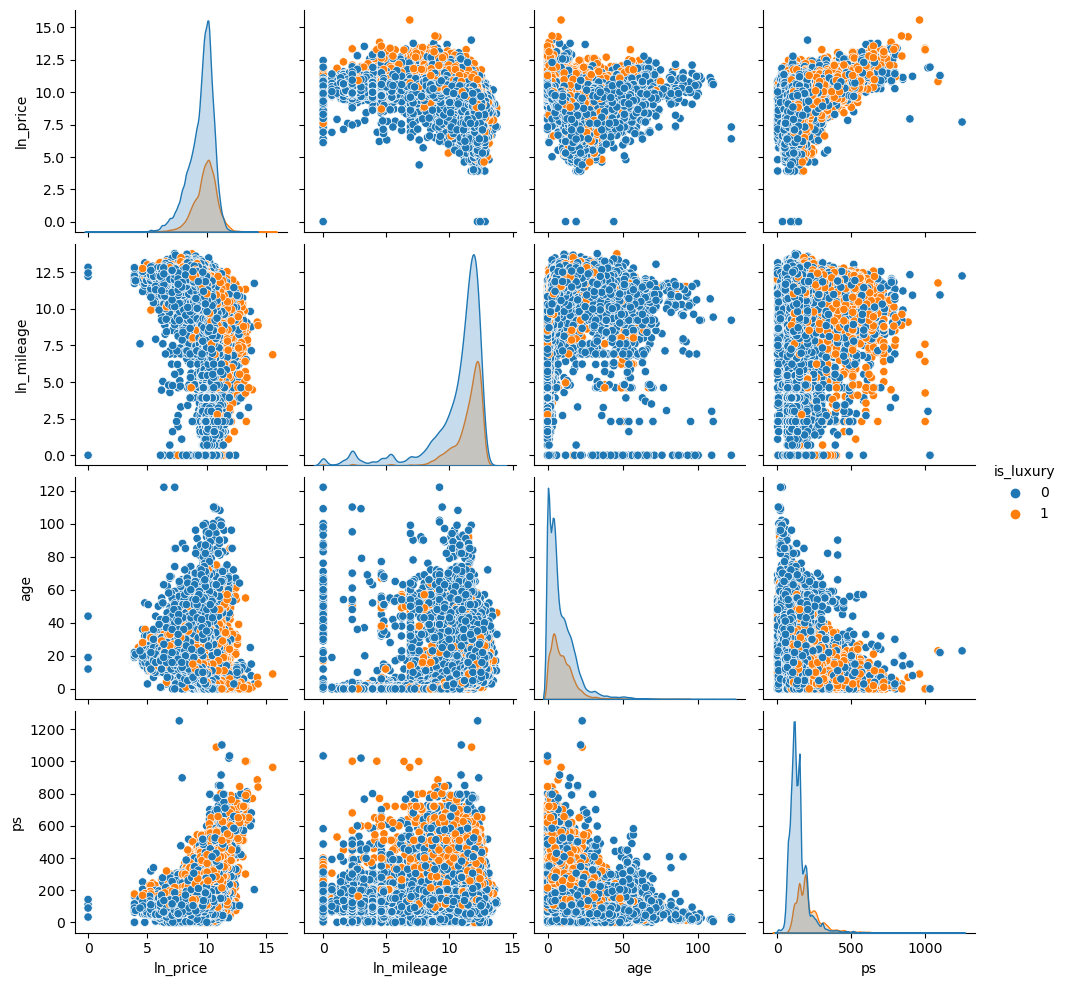

In [16]:
cols = ["ln_price", "ln_mileage", "age", "ps", "is_luxury"]
sns.pairplot(data=df[cols], hue="is_luxury")

Die Korrelationsmatrix der wichtigsten Einflussfaktoren, macht ebenfalls Sinn. KM-Stand und Alter sind negativ korreliert, Ps sind positiv korreliert mit dem Preis. 

<AxesSubplot:>

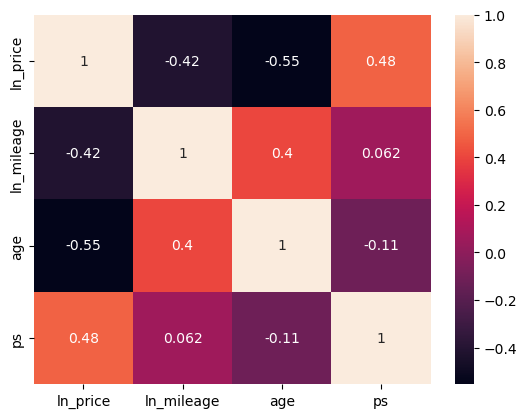

In [63]:
cols = ["ln_price", "ln_mileage", "age", "ps"]
sns.heatmap(df[cols].corr(), annot=True)

Der Datensatz bietet auch andere Möglichkeiten der Auswertungen, wie zB die Top 10 Lieblingsmarken der Österreicher:

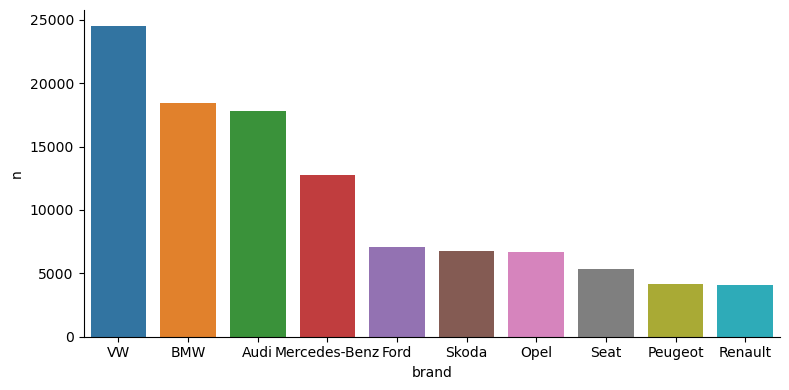

In [17]:
temp = (df
        .filter(["brand"])
        .groupby("brand")
        .agg(n=("brand", "count"))
        .sort_values("n", ascending=False)
        .head(10)
        )
temp = temp.assign(brand=temp.index)
sns.catplot(data=temp, x="brand", y="n", kind="bar", height=4, aspect=8/4)


Oder in welchen Bundesländern am meisten inseriert wird:

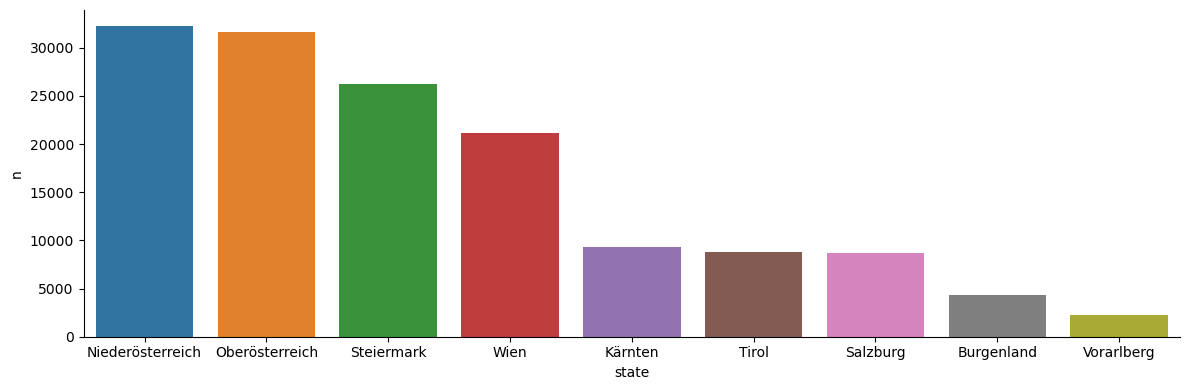

In [18]:
temp = (df
        .filter(["state"])
        .groupby("state")
        .agg(n=("state", "count"))
        .sort_values("n", ascending=False)
        .head(10)
        )
temp = temp.assign(state=temp.index)
sns.catplot(data=temp, x="state", y="n", kind="bar", height=4, aspect=12/4)


Recht ungewöhnlich, dass nicht Wien an erster Stelle ist. Liegt vermutlich daran, dass die Hälfte aller Inserate von gewerblichen Anbietern kommen und es vermutlich mehr Autohäuser in NÖ und OÖ gibt, als in Wien. 

Die Top Autohäuser sind:

In [19]:
(df
  .filter(["orgname", "id"])
  .groupby("orgname")
  .agg(n=("orgname", "count"))
  .sort_values("n", ascending=False)
  .head(10)
)


,n
orgname,
privat,70080
Onlinecars Vertriebs GmbH Gebrauchtwagen-Outlet  Werkstätte  Spenglerei  Lackiererei,1542
Autohaus Mag. Herbert Seidl,968
Automobile Schuster GesmbH,848
Opel & Beyschlag GmbH,796
Onlinecars Vertriebs GmbH,696
SEAT Harb,596
Autohaus Senker GmbH,553
Autohaus Hösch GmbH,390


## 3. Lineare Regression

Einflussfaktoren auf dem Preis lassen sich am besten mittels ökonometrischen Methoden analysieren, wie der linearen Regression. Der Unterschied zum Machine Learning ist, dass sich die Ökonometrie nicht so sehr für predictions interessiert, sondern für die einzelnen Regressionskoeffizienten. Diese geben die Stärke des Effekts an, messen ob ein signifikanter Zusammenhang vorliegt und lassen sich unter "ceteris paribus" Annahmen interpretieren. ML dagegen lässt sich schwerer interpretieren, hat dafür deutlich mehr predictive power. 

Da wir an den Koeffizienten interessiert sind, nutzen wir `statsmodels`.

In [20]:
import statsmodels.api as sm

In [58]:
df.columns

Index(['id', 'price', 'year_model', 'mileage', 'brand', 'model', 'car_type',
       'coordinates', 'postcode', 'state', 'district', 'location', 'orgname',
       'fuel', 'transmission', 'ln_price', 'ln_mileage', 'age', 'has_warranty',
       'is_gewerblich', 'ps', 'has_defect', 'is_servicegepflegt', 'is_leasing',
       'has_alufelgen', 'length_heading', 'is_luxury', 'is_sport', 'd_Diesel',
       'd_Elektro', 'd_Gas', 'd_Hybrid Elektro/Benzin',
       'd_Hybrid Elektro/Diesel', 'd_Wasserstoff', 'd_Automatik',
       'ln_mileage2', 'ps2', 'age2'],
      dtype='object')

In [74]:
y_col = ["ln_price"]
x_col = ["ln_mileage", "ln_mileage2", "age", "ps", "has_warranty",
         "is_gewerblich", "has_defect", "is_servicegepflegt", "is_leasing",
         "has_alufelgen", "is_luxury", "is_sport", "d_Diesel",
         "d_Elektro", "d_Gas", "d_Hybrid Elektro/Benzin",
         "d_Hybrid Elektro/Diesel", "d_Wasserstoff", "d_Automatik"]
y = df[y_col]
x = df[x_col]
x = sm.add_constant(x)

mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                 1.707e+04
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        21:54:33   Log-Likelihood:            -1.2544e+05
No. Observations:              144751   AIC:                         2.509e+05
Df Residuals:                  144731   BIC:                         2.511e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     